## 1. Load essential libraries

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [3]:
data = pd.read_csv('spam.csv' ,encoding='latin1')

In [4]:
data.sample(10)

,V1,V2
4813,ham,"In case you wake up wondering where I am, I fo..."
4280,ham,I got a call from a landline number. . . I am ...
1057,ham,Dear how is chechi. Did you talk to her
113,ham,Yun ah.the ubi one say if ï¿½_ wan call by tom...
2524,spam,Call 09094100151 to use ur mins! Calls cast 10...
5699,ham,Hi. Hope you had a good day. Have a better night.
4604,spam,WINNER!! As a valued network customer you have...
5877,spam,URGENT Your grandson was arrested last night i...
1841,ham,But if she.s drinkin i'm ok.
1309,ham,I wanted to ask Ã¼ to wait 4 me to finish lect...


In [5]:
data.shape

(5880, 2)

## 2. Data Cleaning

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   V1      5880 non-null   object
 1   V2      5880 non-null   object
dtypes: object(2)
memory usage: 92.0+ KB


In [7]:
data.rename(columns={'V1':'Category','V2':'Message'},inplace =True)

In [8]:
data.sample(10)

,Category,Message
5158,ham,S.this will increase the chance of winning.
3994,spam,"You can stop further club tones by replying ""S..."
5386,ham,Mark works tomorrow. He gets out at 5. His wor...
1043,ham,Customer place i will call you.
2293,ham,"If we hit it off, you can move in with me :)"
3855,ham,I will reach office around &lt;DECIMAL&gt; . ...
3823,ham,Ok. I.ll do you right later.
2824,spam,Someone has contacted our dating service and e...
450,ham,Frnd s not juz a word.....not merely a relatio...
1724,ham,Ok... Help me ask if she's working tmr a not?


In [9]:
#check for any null values
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [10]:
#check for duplicate values
data.duplicated().sum()

0

In [11]:
#removing duplicate values
data = data.drop_duplicates(keep='first')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5880 entries, 0 to 5879
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5880 non-null   object
 1   Message   5880 non-null   object
dtypes: object(2)
memory usage: 137.8+ KB


In [13]:
data['Category'].value_counts()

ham     4980
spam     900
Name: Category, dtype: int64

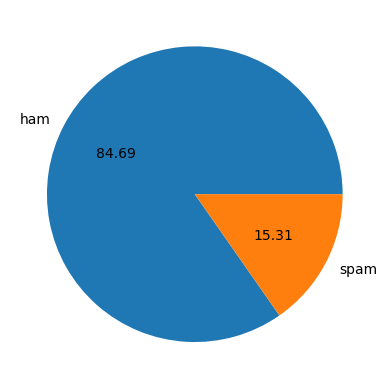

In [14]:
plot.pie(data['Category'].value_counts(),labels=['ham','spam'],autopct="%0.2f")
plot.show()

In [15]:
#no of characters
data['No_character'] = data['Message'].apply(len)

In [16]:
#no of words 
data['No_words'] = data['Message'].apply(lambda x:len(nltk.word_tokenize(x)))

In [17]:
#no of sentence
data['No_sentence'] = data['Message'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [18]:
data.sample(10)


,Category,Message,No_character,No_words,No_sentence
3095,ham,I'm okay. Chasing the dream. What's good. What...,66,18,4
456,spam,You are a winner you have been specially selec...,161,30,3
3888,ham,HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DEA...,159,44,4
2685,ham,Those were my exact intentions,30,5,1
3141,ham,I meant middle left or right?,29,7,1
3031,spam,Knock Knock Txt whose there to 80082 to enter ...,156,31,2
1803,ham,Oh yes I can speak txt 2 u no! Hmm. Did u get ...,53,17,3
2523,ham,Hey darlin.. i can pick u up at college if u t...,84,23,1
4125,ham,"Dear friends, sorry for the late information. ...",198,47,5
4164,ham,Just normal only here :),24,6,1


In [19]:
data[data['Category']=='ham'][['No_character','No_words','No_sentence']].describe()

,No_character,No_words,No_sentence
count,4980.000000,4980.000000,4980.000000
mean,72.472490,17.558233,1.814859
std,57.160801,13.708658,1.284050
min,2.000000,1.000000,1.000000
25%,34.000000,9.000000,1.000000
50%,54.000000,13.000000,1.000000
75%,95.000000,23.000000,2.000000
max,910.000000,220.000000,28.000000


In [20]:
data[data['Category']=='spam'][['No_character','No_words','No_sentence']].describe()

,No_character,No_words,No_sentence
count,900.000000,900.000000,900.000000
mean,139.622222,27.902222,3.014444
std,28.956597,6.705583,1.513312
min,7.000000,2.000000,1.000000
25%,133.000000,25.000000,2.000000
50%,149.500000,29.000000,3.000000
75%,158.000000,32.000000,4.000000
max,225.000000,46.000000,8.000000


## Data preprocessing
* lowercase
* Tokenization
* Removing special characters
* Removing stopwords and punctutation
* Stemming

In [21]:
ps = PorterStemmer()

In [22]:
def transform_text(Message):
    Message = Message.lower()
    Message = nltk.word_tokenize(Message)
    y=[]
    for i in Message:
        if i.isalnum():
            y.append(i)
            
    Message = y[:]
    y.clear()
    
    for i in Message:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    Message = y[:]
    y.clear()
    
    for i in Message:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [23]:
transform_textt = transform_text("No. I meant the calculation is the same. That  &lt;#&gt; units at  &lt;#&gt; . This school is really expensive. Have you started practicing your accent. Because its important. And have you decided if you are doing 4years of dental school or if you'll just do the nmde exam.")
print(transform_textt)

meant calcul lt gt unit lt gt school realli expens start practic accent import decid 4year dental school nmde exam


In [24]:
data['transformed_text']=data['Message'].apply(transform_text)

In [25]:
data.sample(10)

,Category,Message,No_character,No_words,No_sentence,transformed_text
5853,ham,Yeh. Indians was nice. Tho it did kane me off ...,153,43,6,yeh indian nice tho kane bit shud go 4 drink s...
4336,ham,He's just gonna worry for nothing. And he won'...,74,20,2,gon na worri noth wo give money use
5127,ham,Me too. Mark is taking forever to pick up my p...,86,19,2,mark take forev pick prescript pain come back
3519,ham,Wat makes some people dearer is not just de ha...,119,29,2,wat make peopl dearer de happi dat u feel u me...
3909,ham,"I got like $ &lt;#&gt; , I can get some more l...",85,25,2,got like lt gt get later though get whatev fee...
1014,spam,Congratulations ur awarded 500 of CD vouchers ...,150,23,1,congratul ur award 500 cd voucher 125gift guar...
2170,ham,Yes I posted a couple of pics on fb. There's s...,90,24,3,ye post coupl pic fb still snow outsid wake
5811,ham,Yes. Please leave at &lt;#&gt; . So that at ...,69,26,3,ye pleas leav lt gt lt gt leav
3649,spam,You have 1 new voicemail. Please call 08719181...,50,10,2,1 new voicemail pleas call 08719181513
374,ham,Short But Cute : \ Be a good person,36,9,1,short cute good person


In [26]:
spam_cor=[]
for msg in data[data['Category']=='spam']['transformed_text'].tolist():
    for word in msg.split():
        spam_cor.append(word)

In [27]:
count = Counter(spam_cor).most_common(10)

In [28]:
print(count)

[('call', 439), ('free', 236), ('2', 222), ('txt', 195), ('u', 173), ('ur', 167), ('mobil', 167), ('claim', 167), ('prize', 153), ('text', 149)]


In [29]:
ham_cor=[]
for msg in data[data['Category']=='ham']['transformed_text'].tolist():
    for word in msg.split():
        ham_cor.append(word)

In [30]:
count = Counter(ham_cor).most_common(10)

In [31]:
print(count)

[('u', 1014), ('go', 484), ('get', 378), ('2', 340), ('come', 309), ('lt', 307), ('gt', 307), ('got', 272), ('like', 259), ('time', 254)]


## 4. Model Building


In [32]:
tfidf = TfidfVectorizer(max_features=3000)

In [33]:
X = tfidf.fit_transform(data['transformed_text']).toarray()

In [34]:
scaler = MinMaxScaler()
scaler.fit_transform(X)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
Y = data['Category'].values

In [36]:
Y

array(['spam', 'ham', 'spam', ..., 'spam', 'spam', 'spam'], dtype=object)

In [37]:
X_train,X_test,Y_train,Y_test=  train_test_split(X,Y,random_state=2,test_size=0.2)

In [38]:
mnb = MultinomialNB()

In [41]:
mnb.fit(X_train,Y_train)
Y_pred = mnb.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
print(precision_score(Y_test,Y_pred,average='macro'))

0.9829931972789115
0.9841268740070624


In [40]:
pickle.dump(tfidf,open('vector.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))